## Probalistic Confirmed COVID19 Cases- Denmark

**Jorge: remember to reexecute the cell with the photo.**

### Table of contents
[Initialization](#Initialization)  
[Data Importing and Processing](#Data-Importing-and-Processing)
1. [Kalman Filter Modeling: Case of Denmark Data](#1.-Kalman-Filter-Modeling:-Case-of-Denmark-Data)  
    1.1. [Model with the vector c fixed as [0, 1]](#1.1.-Kalman-Filter-Model-vector-c-fixed-as-[0,-1])  
    1.2. [Model with the vector c as a random variable with prior](#1.2.-Kalman-Filter-with-the-vector-c-as-a-random-variable-with-prior)  
    1.3. [Model without input (2 hidden variables)](#1.3.-Kalman-Filter-without-Input)  
2. [Kalman Filter Modeling: Case of Norway Data](#2.-Kalman-Filter-Modeling:-Case-of-Norway-Data)  
    2.1. [Model with the vector c fixed as [0, 1]](#2.1.-Kalman-Filter-Model-vector-c-fixed-as-[0,-1])  
    2.2. [Model with the vector c as a random variable with prior](#2.2.-Kalman-Filter-with-the-vector-c-as-a-random-variable-with-prior)  
    2.3. [Model without input (2 hidden variables)](#2.3.-Kalman-Filter-without-Input)  
3. [Kalman Filter Modeling: Case of Sweden Data](#Kalman-Filter-Modeling:-Case-of-Sweden-Data)  
    3.1. [Model with the vector c fixed as [0, 1]](#3.1.-Kalman-Filter-Model-vector-c-fixed-as-[0,-1])  
    3.2. [Model with the vector c as a random variable with prior](#3.2.-Kalman-Filter-with-the-vector-c-as-a-random-variable-with-prior)  
    3.3. [Model without input (2 hidden variables)](#3.3.-Kalman-Filter-without-Input)  

## Initialization

In [1]:
from os.path import join, pardir

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns

from jax import lax, random, vmap
from jax.scipy.special import logsumexp
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import StandardScaler

np.random.seed(2103)

In [2]:
ROOT = pardir
DATA = join(ROOT, "data", "raw")

# random seed
np.random.seed(42)

#plot style
plt.style.use('ggplot')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Data Importing and Processing

The data in this case are the confirmed cases of the COVID-19 and the the mobility data (from Google) for three specific countries: Denmark, Sweden and Norway.


In [3]:
adress = join(ROOT, "data", "processed")
data = pd.read_csv(join(adress, 'data_five_mob_cov_daily.csv'),parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
Date                    462 non-null datetime64[ns]
Country                 462 non-null object
Confirmed               462 non-null int64
daily_confirmed_case    462 non-null int64
ret_rec_ch              462 non-null int64
gr_ph_ch                459 non-null float64
par_cha                 462 non-null int64
tra_sta_ch              462 non-null int64
wor_ch                  462 non-null int64
res_ch                  462 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 36.2+ KB


In [4]:
data.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,0,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,2,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,1,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,0,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,2,11,-5.0,28,1,2,0


Handy functions to split the data, train the models and plot the results.

In [5]:
def split_forecast(df, n_train=65):
    """Split dataframe `df` as training, test and input mobility data."""
    # just take the first 4 mobility features
    X = df.iloc[:, 4:8].values.astype(np.float_)
    # confirmed cases
    y = df.iloc[:, 2].values.astype(np.float_)

    idx_train = [*range(0,n_train)]
    idx_test = [*range(n_train, len(y))]

    y_train = y[:n_train]
    y_test = y[n_train:]

    return X, y_train, y_test


def train_kf(model, data, n_train, n_test, num_samples=9000, num_warmup=3000, **kwargs):
    """Train a Kalman Filter model."""
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    nuts_kernel = NUTS(model=model)
    # burn-in is still too much in comparison with the samples
    mcmc = MCMC(
        nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=1
    )
    mcmc.run(rng_key_, T=n_train, T_forecast=n_test, obs=data, **kwargs)
    return mcmc


def get_samples(mcmc):
    """Get samples from variables in MCMC."""
    return {k: v for k, v in mcmc.get_samples().items()}


def plot_samples(hmc_samples, nodes, dist=True):
    """Plot samples from the variables in `nodes`."""
    for node in nodes:
        if len(hmc_samples[node].shape) > 1:
            n_vars = hmc_samples[node].shape[1]
            for i in range(n_vars):
                plt.figure(figsize=(4, 3))
                if dist:
                    sns.distplot(hmc_samples[node][:, i], label=node + "%d" % i)
                else:
                    plt.plot(hmc_samples[node][:, i], label=node + "%d" % i)
                plt.legend()
                plt.show()
        else:
            plt.figure(figsize=(4, 3))
            if dist:
                sns.distplot(hmc_samples[node], label=node)
            else:
                plt.plot(hmc_samples[node], label=node)
            plt.legend()
            plt.show()

    
def plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test):
    """Plot the results of forecasting (dimension are different)."""
    y_hat = hmc_samples["y_pred"].mean(axis=0)
    y_std = hmc_samples["y_pred"].std(axis=0)
    y_pred_025 = y_hat - 1.96 * y_std
    y_pred_975 = y_hat + 1.96 * y_std
    plt.plot(idx_train, y_train, "b-")
    plt.plot(idx_test, y_test, "bx")
    plt.plot(idx_test[:-1], y_hat, "r-")
    plt.plot(idx_test[:-1], y_pred_025, "r--")
    plt.plot(idx_test[:-1], y_pred_975, "r--")
    plt.fill_between(idx_test[:-1], y_pred_025, y_pred_975, alpha=0.3)
    plt.legend(
        [
            "true (train)",
            "true (test)",
            "forecast",
            "forecast + stddev",
            "forecast - stddev",
        ]
    )
    plt.show()

n_train = 65  # number of points to train
n_test = 20   # number of points to forecast
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, n_train+n_test)]

## 1. Kalman Filter Modeling: Case of Denmark Data

In [6]:
data_dk=data[data['Country'] == "Denmark"]
data_dk.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,0,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,2,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,1,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,0,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,2,11,-5.0,28,1,2,0


In [7]:
print("The length of the full dataset for Denmark is:" + " " )
print(len(data_dk))

The length of the full dataset for Denmark is: 
85


Prepare input of the models (we are using numpyro so the inputs are numpy arrays).

In [8]:
X, y_train, y_test = split_forecast(data_dk)

### 1.1. Kalman Filter Model vector c fixed as [0, 1]

First model: the sampling distribution is replaced by one fixed variable $c$.

In [6]:
def f(carry, input_t):
    x_t, noise_t = input_t
    W, beta, z_prev, tau = carry
    z_t = beta * z_prev + W @ x_t + noise_t
    z_prev = z_t
    return (W, beta, z_prev, tau), z_t


def model_wo_c(T, T_forecast, x, obs=None):
    """Define KF with inputs and fixed sampling dist."""
    # Define priors over beta, tau, sigma, z_1
    W = numpyro.sample(
        name="W", fn=dist.Normal(loc=jnp.zeros((2, 4)), scale=jnp.ones((2, 4)))
    )
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=0.1))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 2,),
    )
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    obs_mean = z_collection[:T, 1]
    pred_mean = z_collection[T:, 1]

    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [10]:
mcmc = train_kf(model_wo_c, y_train, n_train, n_test, x=X[2:])

sample: 100%|██████████| 12000/12000 [04:46<00:00, 41.87it/s, 1023 steps of size 7.60e-04. acc. prob=0.54]


Plots of the distribution of the samples for each variable.

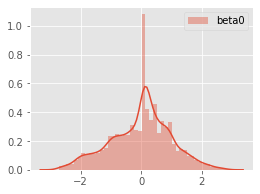

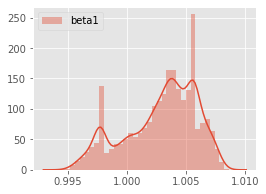

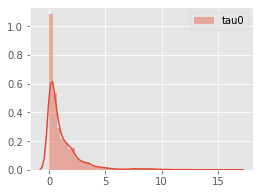

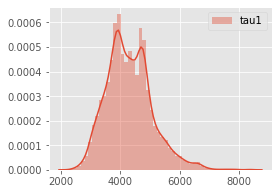

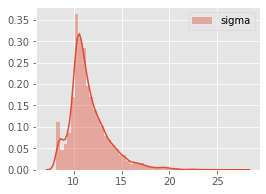

In [11]:
hmc_samples = get_samples(mcmc)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

Forecasting prediction, all the datapoints in the test set are within the Confidence Interval.

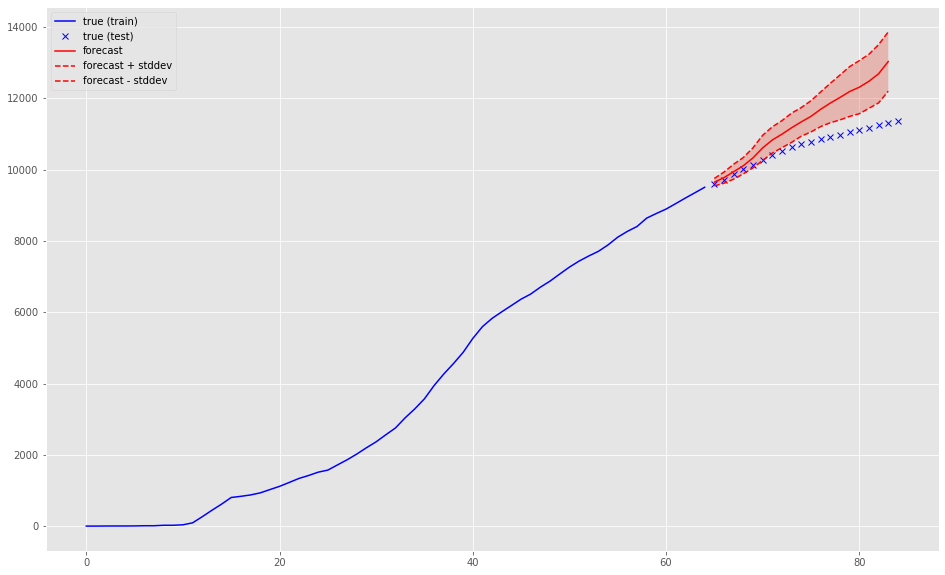

In [12]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 1.2. Kalman Filter with the vector c as a random variable with prior

Second model: the sampling distribution is a Normal distribution $c$.

In [7]:
def model_w_c(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    W = numpyro.sample(
        name="W", fn=dist.Normal(loc=jnp.zeros((2, 4)), scale=jnp.ones((2, 4)))
    )
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.array([0.0, 0.0]), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.array([2,2])))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 2,),
    )
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(
        name="c", fn=dist.Normal(loc=jnp.array([[0.0], [0.0]]), scale=jnp.ones((2, 1)))
    )
    obs_mean = jnp.dot(z_collection[:T, :], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:, :], c).squeeze()

    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [14]:
mcmc2 = train_kf(model_w_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 12000/12000 [06:47<00:00, 29.46it/s, 1023 steps of size 4.92e-04. acc. prob=0.85]


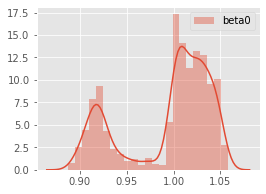

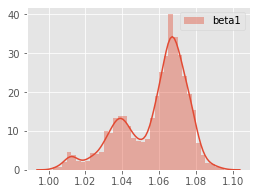

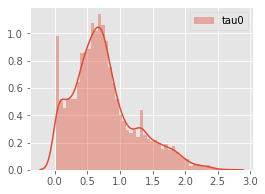

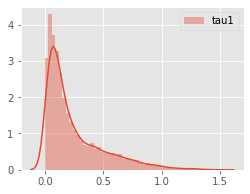

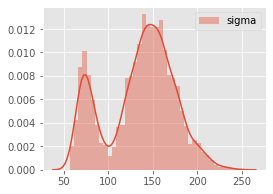

In [15]:
hmc_samples = get_samples(mcmc2)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

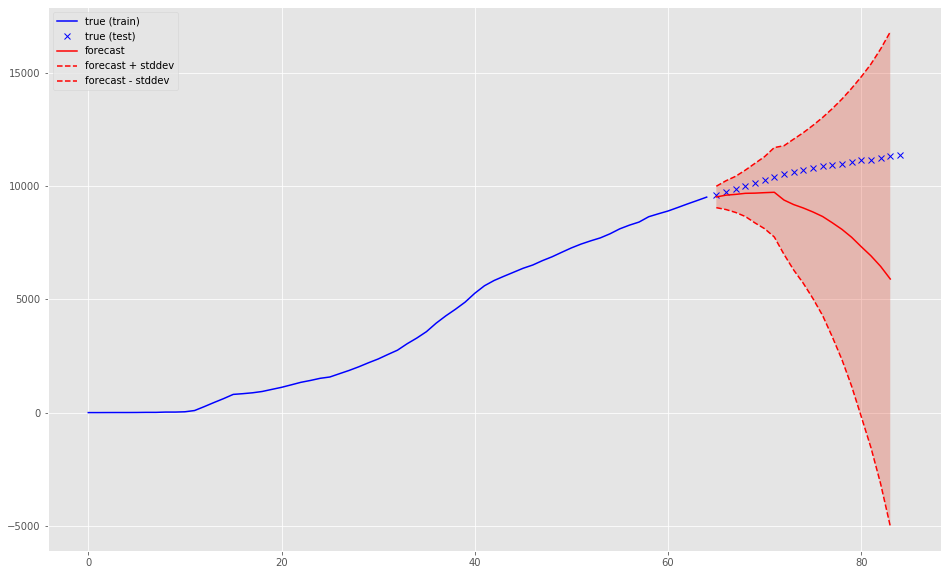

In [16]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 1.3. Kalman Filter without Input

Third model: no input mobility data, **two** hidden states.

In [8]:
def f_s(carry, noise_t):
    """Propagate forward the time series."""
    beta, z_prev, tau = carry
    z_t = beta * z_prev + noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def twoh_c_kf(T, T_forecast, obs=None):
    """Define Kalman Filter with two hidden variates."""
    # Define priors over beta, tau, sigma, z_1
    # W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.array([0.0, 0.0]), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.array([10,10])))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=5))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 2,),
    )
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f_s, carry, noises, T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(
        name="c", fn=dist.Normal(loc=jnp.array([[0.0], [0.0]]), scale=jnp.ones((2, 1)))
    )
    obs_mean = jnp.dot(z_collection[:T, :], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:, :], c).squeeze()

    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [18]:
mcmc3 = train_kf(twoh_c_kf, y_train, n_train, n_test, num_samples=12000, num_warmup=5000)

sample: 100%|██████████| 17000/17000 [06:55<00:00, 40.92it/s, 1023 steps of size 2.57e-03. acc. prob=0.61] 


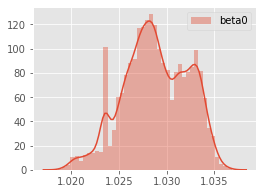

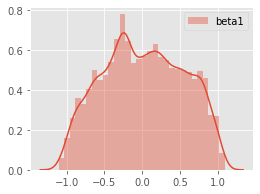

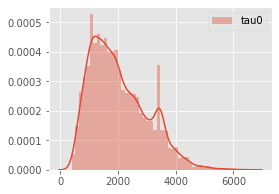

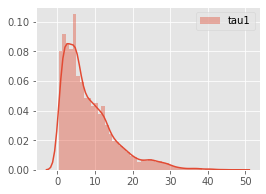

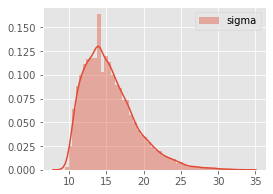

In [19]:
hmc_samples = get_samples(mcmc3)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

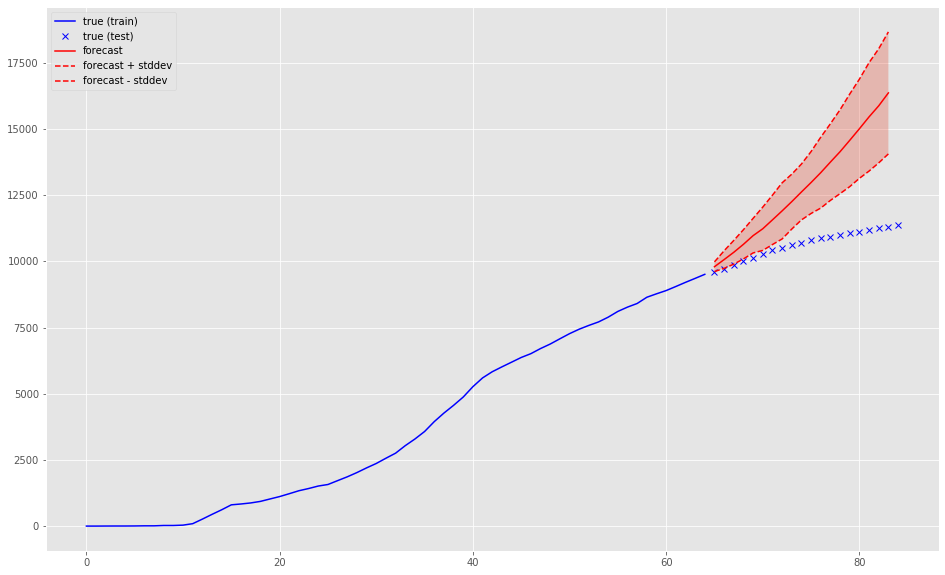

In [21]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## 2. Kalman Filter Modeling: Case of Finland Data

In [9]:
data_fi=data[data['Country'] == "Finland"]
data_fi.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
268,2020-02-15,Finland,1,0,3,0.0,-11,0,-2,0
269,2020-02-16,Finland,1,0,-3,-2.0,-24,-8,-3,1
270,2020-02-17,Finland,1,0,3,2.0,10,-10,-13,2
271,2020-02-18,Finland,1,0,2,2.0,22,-9,-13,2
272,2020-02-19,Finland,1,0,4,1.0,34,-8,-13,1


In [10]:
print("The length of the full dataset for Finland is:" + " " )
print(len(data_fi))

The length of the full dataset for Finland is: 
97


In [11]:
n_train = 70  # number of points to train
n_test = 27   # number of points to forecast
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, n_train+n_test)]

In [12]:
X, y_train, y_test = split_forecast(data_fi, n_train)

### 2.1. Kalman Filter Model vector c fixed as [0, 1]

In [13]:
mcmc_fi = train_kf(model_wo_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 12000/12000 [05:01<00:00, 39.76it/s, 838 steps of size 1.23e-03. acc. prob=0.44] 


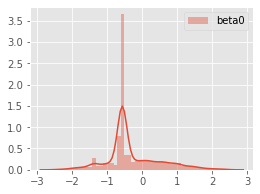

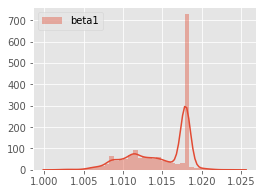

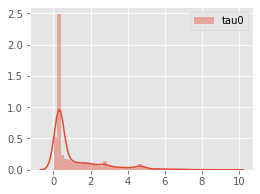

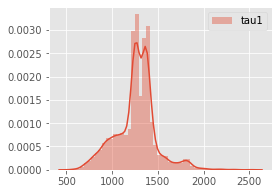

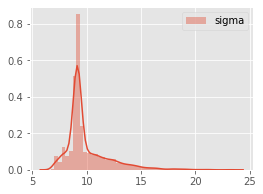

In [14]:
hmc_samples = get_samples(mcmc_fi)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

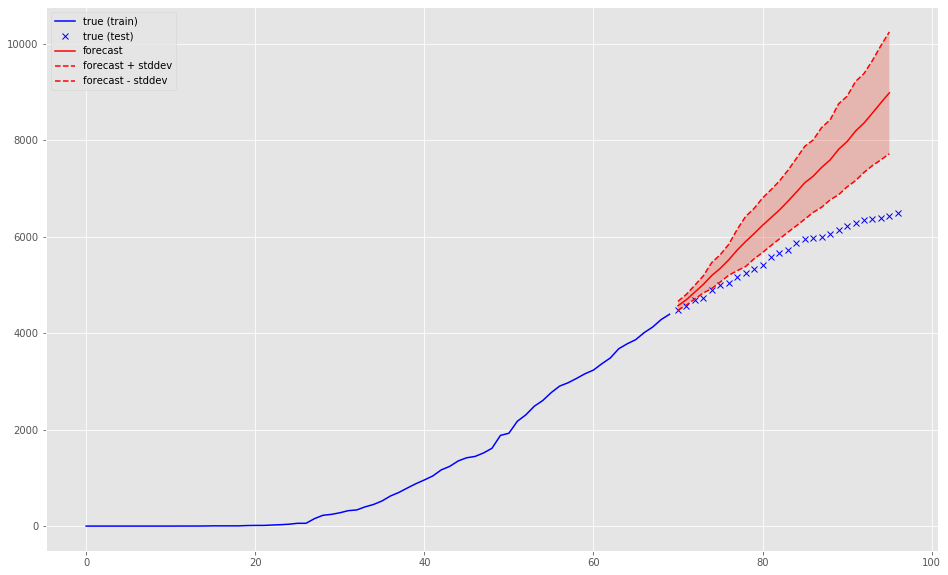

In [15]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 2.2. Kalman Filter with the vector c as a random variable with prior

In [16]:
mcmc2_fi = train_kf(model_w_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 12000/12000 [07:46<00:00, 25.75it/s, 1023 steps of size 5.18e-04. acc. prob=0.81]


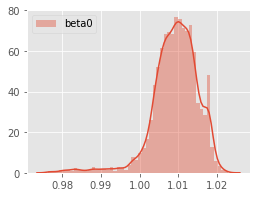

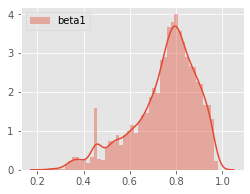

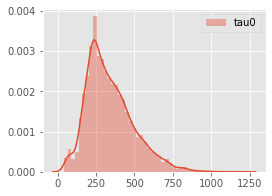

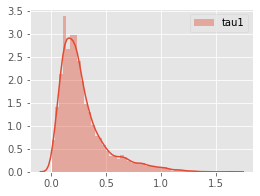

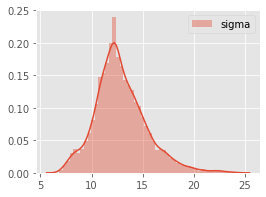

In [17]:
hmc_samples = get_samples(mcmc2_fi)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

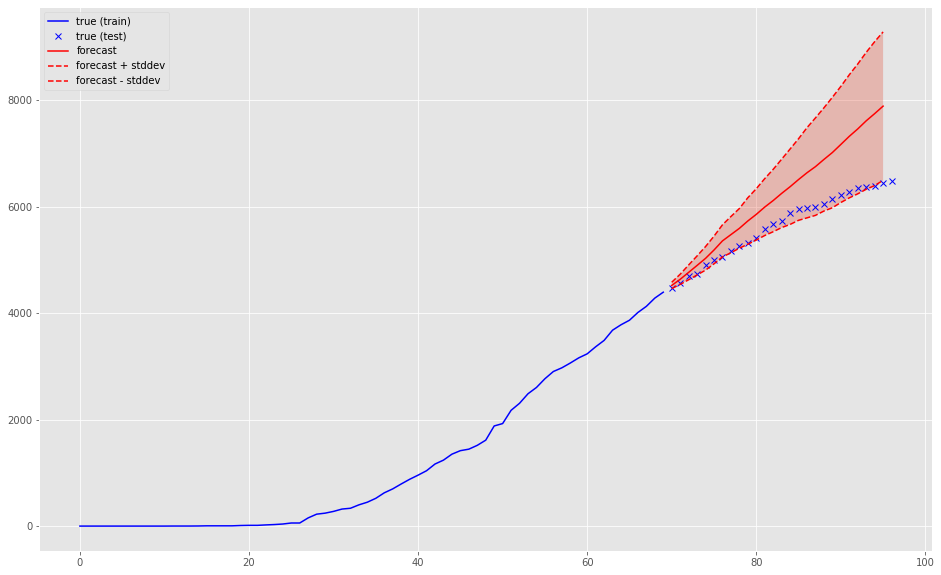

In [18]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 2.3. Kalman Filter without Input

In [19]:
mcmc3_fi = train_kf(twoh_c_kf, y_train, n_train, n_test, num_samples=7000, num_warmup=1000)

sample: 100%|██████████| 8000/8000 [00:53<00:00, 149.22it/s, 12 steps of size 1.63e-04. acc. prob=0.13]  


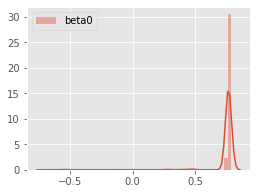

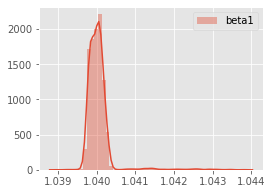

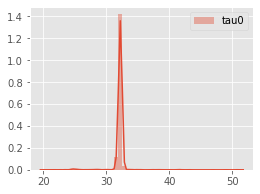

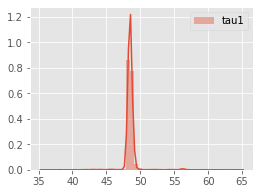

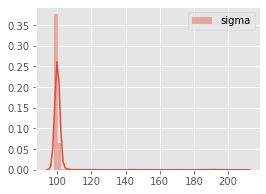

In [20]:
hmc_samples = get_samples(mcmc3_fi)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

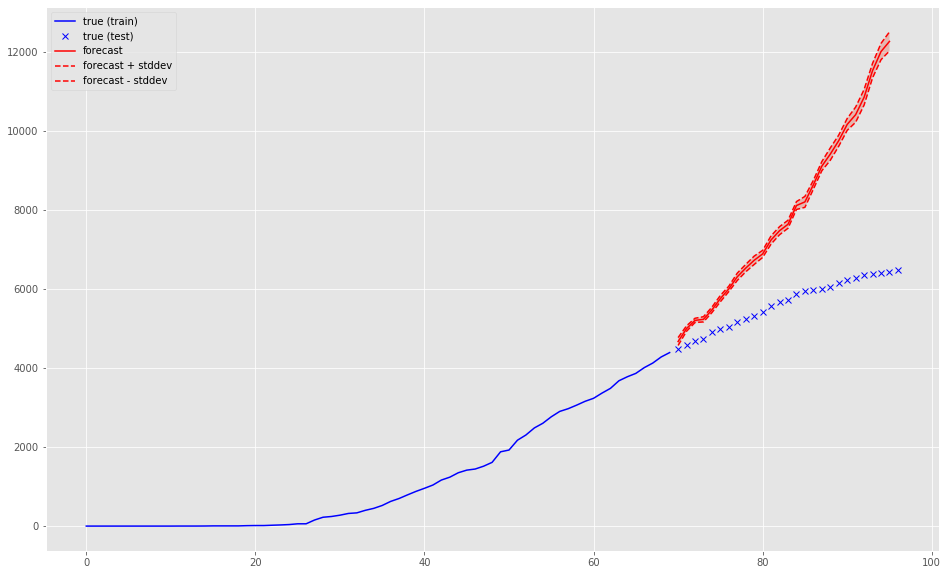

In [21]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## 3. Kalman Filter Modeling: Case of Sweden Data

In [18]:
data_sw=data[data['Country'] == "Sweden"]
data_sw.head(5)

,Date,Country,Confirmed,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
171,2020-02-15,Sweden,1,2,0.0,3,4,-2,0
172,2020-02-16,Sweden,1,-10,-7.0,-30,-11,-5,2
173,2020-02-17,Sweden,1,-4,-3.0,-3,-6,-6,2
174,2020-02-18,Sweden,1,0,0.0,13,-4,-5,1
175,2020-02-19,Sweden,1,3,1.0,26,-3,-5,1


In [19]:
print("The length of the full dataset for Sweden is:" + " " )
print(len(data_sw))

The length of the full dataset for Sweden is: 
97


In [21]:
n_train = 75  # number of points to train
n_test = 22   # number of points to forecast
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, n_train+n_test)]

In [24]:
X, y_train, y_test = split_forecast(data_sw, n_train)

### 3.1. Kalman Filter Model vector c fixed as [0, 1]

In [25]:
mcmc_sw = train_kf(model_wo_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 12000/12000 [03:07<00:00, 64.08it/s, 7 steps of size 9.13e-03. acc. prob=0.37]   


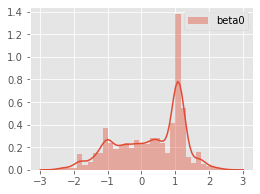

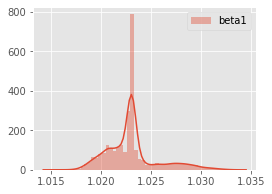

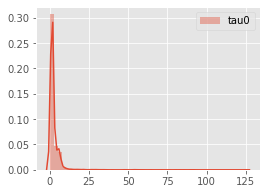

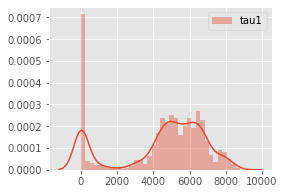

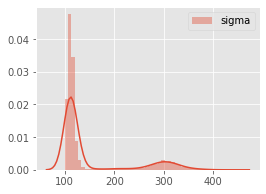

In [26]:
hmc_samples = get_samples(mcmc_sw)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

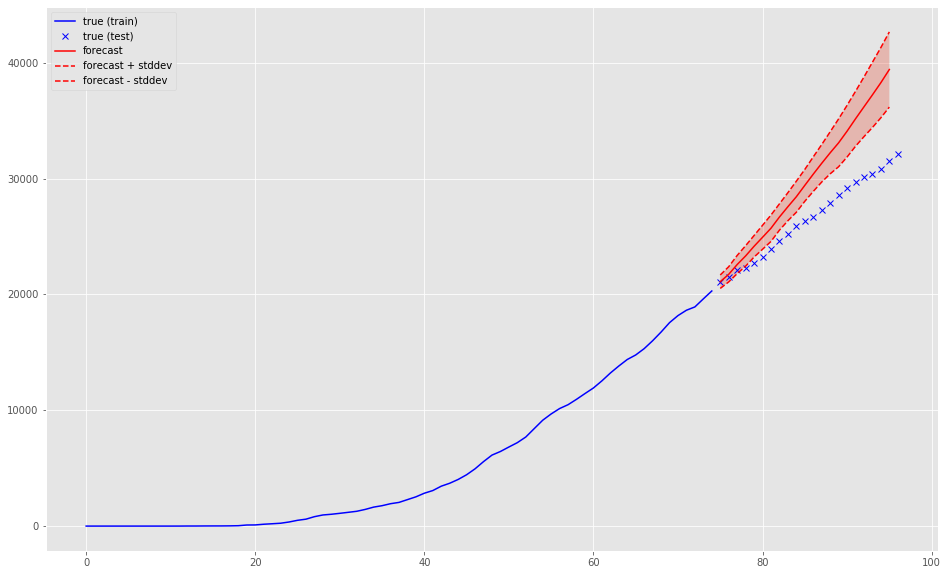

In [27]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 3.2. Kalman Filter with the vector c as a random variable with prior

In [28]:
mcmc2_sw = train_kf(model_w_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 12000/12000 [07:50<00:00, 25.49it/s, 1023 steps of size 3.14e-04. acc. prob=0.75]


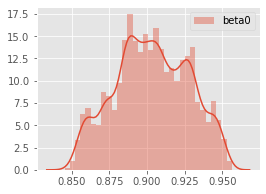

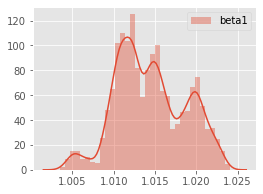

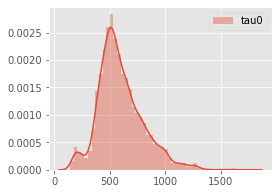

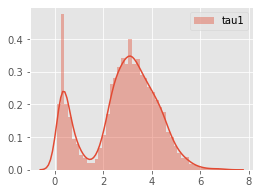

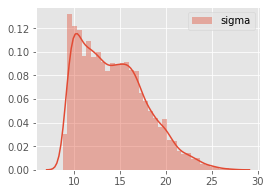

In [29]:
hmc_samples = get_samples(mcmc2_sw)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

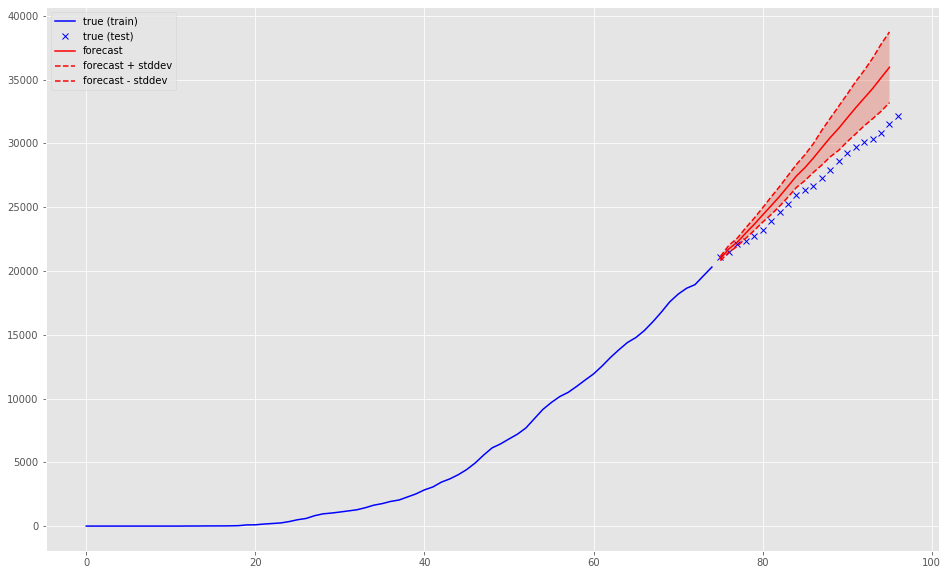

In [30]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 3.3. Kalman Filter without Input

In [31]:
mcmc3_sw = train_kf(twoh_c_kf, y_train, n_train, n_test)

sample: 100%|██████████| 12000/12000 [04:13<00:00, 47.42it/s, 106 steps of size 3.37e-03. acc. prob=0.37] 


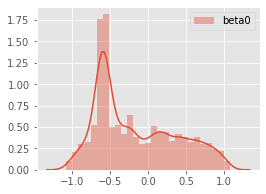

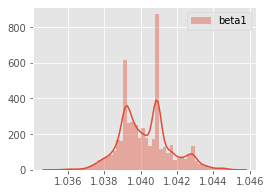

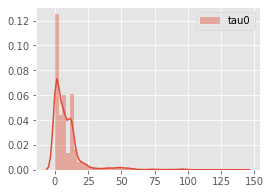

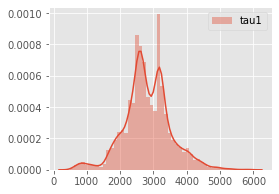

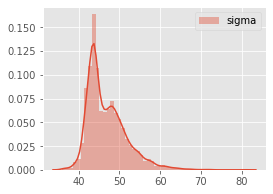

In [32]:
hmc_samples = get_samples(mcmc3_sw)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

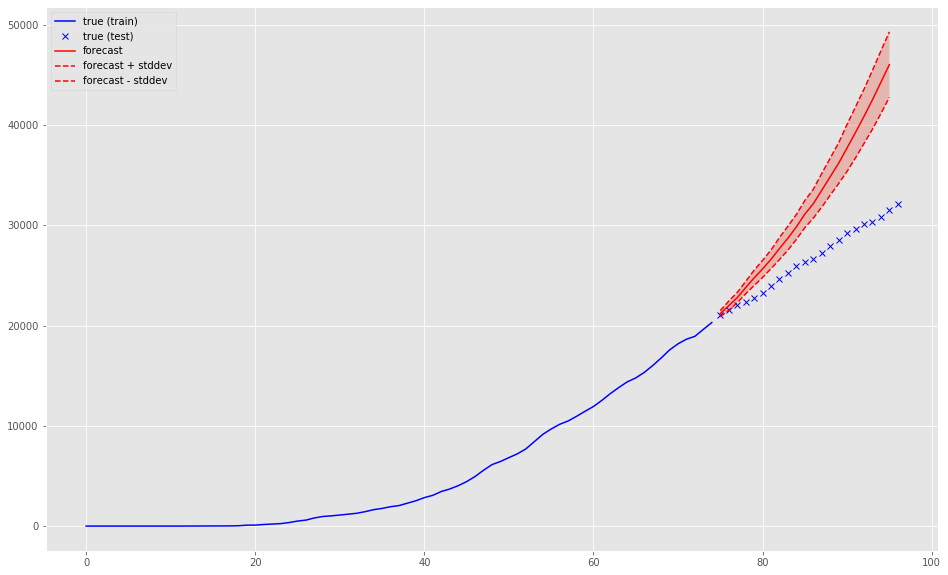

In [33]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

Save results to rerun the plotting functions.

In [22]:
import pickle

In [23]:
MODELS = join(ROOT, "models")
for i, mc in enumerate([mcmc_fi, mcmc2_fi, mcmc3_fi]):
    with open(join(MODELS, f"hmc_fi_{i}.pickle"), "wb") as f:
        pickle.dump(get_samples(mc), f)

## Gaussian Process